In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
import joblib


In [9]:
df = pd.read_csv('../datasets/RIASEC_Dataset_clustered.csv')
X = df.drop(columns=['major_cluster'])
y = df['major_cluster']

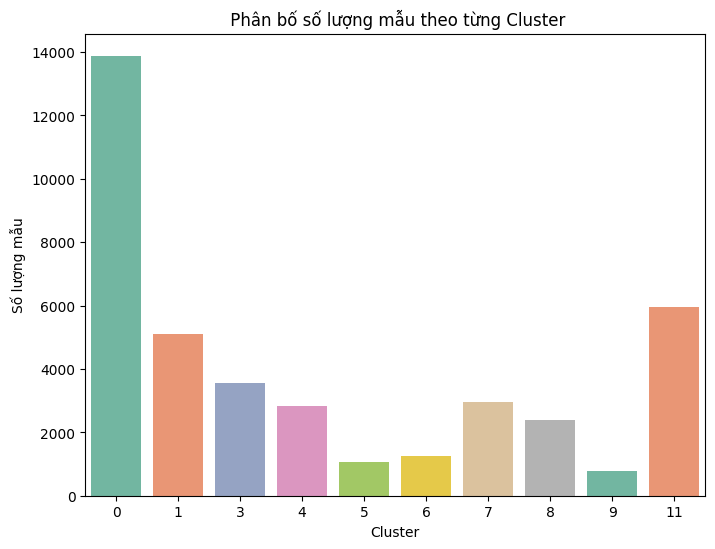

📈 Số lượng mẫu mỗi cluster:
major_cluster
0     13885
1      5113
3      3550
4      2837
5      1061
6      1244
7      2948
8      2380
9       786
11     5950
Name: count, dtype: int64


In [10]:
# --- Vẽ biểu đồ phân bố các cluster ---
plt.figure(figsize=(8, 6))
sns.countplot(x='major_cluster', hue='major_cluster', data=df, palette='Set2', legend=False)
plt.title(" Phân bố số lượng mẫu theo từng Cluster")
plt.xlabel("Cluster")
plt.ylabel("Số lượng mẫu")
plt.show()

# --- In số lượng mẫu từng cluster ---
print("📈 Số lượng mẫu mỗi cluster:")
print(df['major_cluster'].value_counts().sort_index())

In [11]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

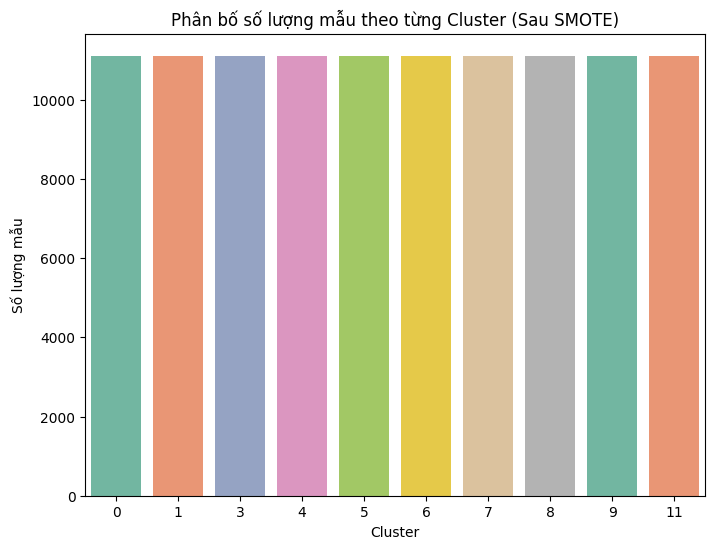

📈 Số lượng mẫu mỗi cluster (Sau SMOTE):
major_cluster
0     11108
1     11108
3     11108
4     11108
5     11108
6     11108
7     11108
8     11108
9     11108
11    11108
Name: count, dtype: int64


In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_resampled, hue=y_train_resampled, palette='Set2', legend=False)
plt.title("Phân bố số lượng mẫu theo từng Cluster (Sau SMOTE)")
plt.xlabel("Cluster")
plt.ylabel("Số lượng mẫu")
plt.show()

print("📈 Số lượng mẫu mỗi cluster (Sau SMOTE):")
print(pd.Series(y_train_resampled).value_counts().sort_index())

In [16]:
k_range = range(31, 41)
mean_f1_scores = []

print("\n🚀 Đang tìm k tốt nhất (theo F1 Macro)...")
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Đánh giá bằng f1_macro
    scores = cross_val_score(knn, X_train_resampled, y_train_resampled, cv=kfold, scoring='f1_macro')
    mean_f1 = scores.mean()
    mean_f1_scores.append(mean_f1)
    print(f"k={k:2d} | F1_macro trung bình: {mean_f1:.4f}")


🚀 Đang tìm k tốt nhất (theo F1 Macro)...
k=31 | F1_macro trung bình: 0.7226
k=32 | F1_macro trung bình: 0.7202
k=33 | F1_macro trung bình: 0.7170
k=34 | F1_macro trung bình: 0.7140
k=35 | F1_macro trung bình: 0.7113
k=36 | F1_macro trung bình: 0.7080
k=37 | F1_macro trung bình: 0.7052
k=38 | F1_macro trung bình: 0.7028
k=39 | F1_macro trung bình: 0.7001
k=40 | F1_macro trung bình: 0.6973


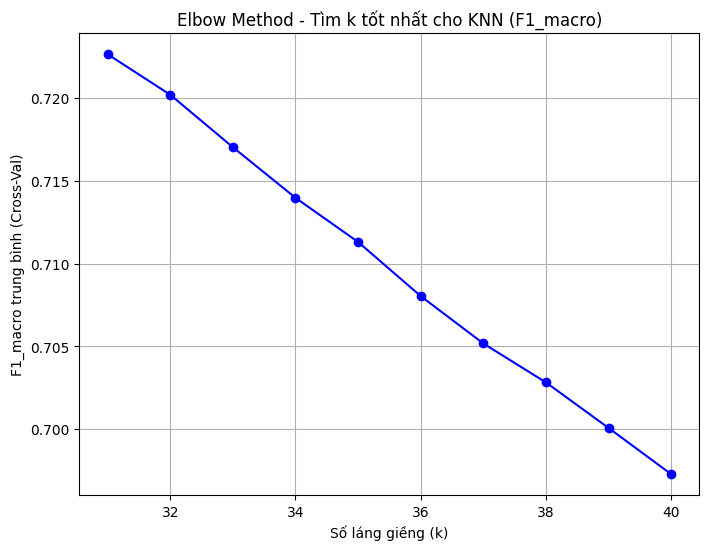

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(k_range, mean_f1_scores, marker='o', linestyle='-', color='b')
plt.title("Elbow Method - Tìm k tốt nhất cho KNN (F1_macro)")
plt.xlabel("Số láng giềng (k)")
plt.ylabel("F1_macro trung bình (Cross-Val)")
plt.grid(True)
plt.show()

In [ ]:
best_k = k_range[np.argmax(mean_f1_scores)]
print(f"\n🏆 k tốt nhất: {best_k} với F1_macro = {max(mean_f1_scores):.4f}")


🏆 k tốt nhất: 3 với F1_macro = 0.8512


In [62]:
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(n_neighbors=3)

In [63]:
y_pred = best_knn.predict(X_test)
test_f1 = f1_score(y_test, y_pred, average='macro')
print(f"✅ F1_macro trên tập test với k={best_k}: {test_f1:.4f}")

✅ F1_macro trên tập test với k=3: 0.1990


In [48]:
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))



📄 Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.11      0.18      2777
           1       0.28      0.24      0.26      1023
           3       0.20      0.23      0.21       710
           4       0.15      0.25      0.19       567
           5       0.05      0.19      0.08       212
           6       0.10      0.24      0.14       249
           7       0.14      0.23      0.17       590
           8       0.22      0.41      0.28       476
           9       0.06      0.24      0.09       157
          11       0.41      0.31      0.35      1190

    accuracy                           0.21      7951
   macro avg       0.22      0.24      0.20      7951
weighted avg       0.36      0.21      0.22      7951



In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title(f"Confusion Matrix (k={best_k})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
joblib.dump(scaler, "../models/scaler_knn.pkl")
joblib.dump(best_knn, "../models/knn_best_model.pkl")

print("✅ Đã lưu scaler thành scaler_knn.pkl")
print("✅ Đã lưu model thành knn_best_model.pkl")